<a href="https://colab.research.google.com/github/bheinri2/DL_Speech_Recognition/blob/main/Preprocessing_training_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import librosa #, librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/jbuchner/synthetic-speech-commands-dataset")

100%|██████████| 1.77G/1.77G [00:19<00:00, 96.7MB/s]


In [5]:
od.download("https://www.kaggle.com/joserzapata/free-spoken-digit-dataset-fsdd")

 32%|███▏      | 5.00M/15.5M [00:00<00:00, 40.7MB/s]

100%|██████████| 15.5M/15.5M [00:00<00:00, 81.2MB/s]


In [6]:
FILE_DIR_1 = "/content/free-spoken-digit-dataset-fsdd/recordings"
FILE_DIR_2 = "/content/synthetic-speech-commands-dataset/augmented_dataset/augmented_dataset"


#### dataset 1: spoken digits

In [7]:
# Load spoken digits audio files into padded numpy arrays and store in a list
# Takes 1 min 13 sec
max_length = 0
#audio_signals_1 = []
for root, dirs, files in os.walk(FILE_DIR_1):
  for ffile in files:
    #print(ffile)
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    max_length = max(audio_time_series.size, max_length)
    
audio_signals_1 = []
labels_1 = []
for root, dirs, files in os.walk(FILE_DIR_1):
  for ffile in files:
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    padding = max_length - audio_time_series.size
    padded = np.pad(audio_time_series, (0, padding), 'constant', 
                    constant_values=(0, 0))
    #print(padded)
    #print(padded.size)
    audio_signals_1.append(padded)
    y_num = int(str(ffile)[0])
    labels_1.append(y_num)
    #print(sr)

In [8]:
import IPython.display as ipd
n = 503
print(labels_1[n])
#y, sr = librosa.load(audio_signals_1[n])
ipd.Audio(audio_signals_1[n],rate=sr)

4


#### dataset 2: spoken words

In [ ]:
# This didn't finish after 20 mins
max_length = 0
audio_signals_2 = []
labels_2 = []
#classes = []
for root, dirs, files in os.walk(FILE_DIR_2):
  #for dir in dirs:
  #  classes.append(str(dir))
  for ffile in files:
    file_path = os.path.join(root, ffile)
    #print(file_path.split('/')[5])
    labels_2.append(file_path.split('/')[5]) # appends the name of the lowest level directory for each file (which is each files corresponding label)
    audio_time_series, sr = librosa.load(file_path)
    audio_signals_2.append(audio_time_series)
    max_length = max(audio_time_series.size, max_length)

# padding each audio signal
for signal in audio_signals_2:
  padding = max_length - signal.size
  padded_signal = np.pad(signal, (0,padding), 'constant', 
                         constant_values=(0,0))
'''    
audio_signals_1 = []
for root, dirs, files in os.walk(FILE_DIR_2):
  for ffile in files:
    file_path = os.path.join(root, ffile)
    audio_time_series, sr = librosa.load(file_path)
    padding = max_length - audio_time_series.size
    padded = np.pad(audio_time_series, (0, padding), 'constant', 
                    constant_values=(0, 0))
    #print(padded)
    #print(padded.size)
    audio_signals_1.append(padded)
    #print(sr)
'''

"    \naudio_signals_1 = []\nfor root, dirs, files in os.walk(FILE_DIR_2):\n  for ffile in files:\n    file_path = os.path.join(root, ffile)\n    audio_time_series, sr = librosa.load(file_path)\n    padding = max_length - audio_time_series.size\n    padded = np.pad(audio_time_series, (0, padding), 'constant', \n                    constant_values=(0, 0))\n    #print(padded)\n    #print(padded.size)\n    audio_signals_1.append(padded)\n    #print(sr)\n"

### Converting samples to mel-spectrograms ###

#### Helper Functions ####

In [9]:
# handles individual signal conversion
def signal_to_mel_spectrogram(signal, hop_length, n_fft):
  ''' converts a given audio signal to a mel spectrogram
  parameters: 
    signal: self-explanatory
    hop_length: number of samples to shift between transformations
    n_fft: number of samples taken per fast fourier transformations
  '''
  # Short-time Fourier Transformation on our audio data
  audio_stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
  # gathering the absolute values for all values in our audio_stft 
  spectrogram = np.abs(audio_stft)
  # Converting the amplitude to decibels
  return librosa.amplitude_to_db(spectrogram)

In [10]:
# plots converted spectrograms (NOTE: for testing purposes)
def plot_spectro(spectrogram, sample_rate, hop_length):
  # Plotting the short-time Fourier Transformation
  plt.figure(figsize=(20, 5))
  # Using librosa.display.specshow() to create our spectrogram
  librosa.display.specshow(spectrogram, sr=sample_rate, x_axis='time', y_axis='hz', hop_length=hop_length, cmap='magma')
  plt.colorbar(label='Decibels')
  plt.title('Spectrogram (dB)', fontdict=dict(size=18))
  plt.xlabel('Time', fontdict=dict(size=15))
  plt.ylabel('Frequency', fontdict=dict(size=15))
  plt.show()

### Free-spoken Digit dataset conversion: ### 

In [11]:
#### BATCH CONVERSION for first (faster) set ####
### TODO: figure out best values for n_fft, hop_length
n_fft = 2048 # number of samples in a window per fft
hop_length = 512 # amount of samples we are shifting after each fft
mel_spectrograms_1 = [] # list to store each converted signal

### actual conversion process
for signal in audio_signals_1:
  ms = signal_to_mel_spectrogram(signal, hop_length, n_fft)
  mel_spectrograms_1.append(ms)

In [12]:
### Final X,Y data:
# X = mel_spectrograms_1
# Y = labels_1

#print(mel_spectrograms_1[4].shape)

mel_spectrograms_1 = np.array(mel_spectrograms_1)
labels_1 = np.array(labels_1)
print(mel_spectrograms_1.shape)
print(labels_1.shape)


(3000, 1025, 99)
(3000,)


In [ ]:
'''
def split_data(X, Y, v_ratio=0.2, t_ratio=0.1):
  v_split = int(X.shape[0]*(1-v_ratio-t_ratio))
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:v_split],       Y[0:v_split]
  X_valid, Y_valid  = X[v_split:t_split], Y[v_split:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test '''

In [13]:
def split_data(X, Y, t_ratio=0.3):
  t_split = int(X.shape[0]*(1-t_ratio))
  X_train, Y_train  = X[0:t_split],       Y[0:t_split]
  X_test , Y_test   = X[t_split:],        Y[t_split:]
  return X_train, Y_train, X_test, Y_test

In [14]:
### creating X_train/X_test, Y_train/Y_test data splits
X_train, y_train, X_test, y_test = split_data(mel_spectrograms_1, labels_1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2100, 1025, 99)
(2100,)
(900, 1025, 99)
(900,)


#### Model

In [15]:
### Useful imports for defining our model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
from tensorflow.keras.initializers import GlorotNormal, HeNormal # https://www.tensorflow.org/api_docs/python/tf/keras/initializers
from tensorflow.keras.callbacks import EarlyStopping # early stopping

from tensorflow.keras.utils import to_categorical

In [16]:
# reshaping 3D tensors to 4D tensors for fully-connected layers
X_train = X_train.reshape(-1, 1025, 99, 1) # FIXME (batch, rows, columns, channels)
# 60000*28*28
# np.extend_dims(X_train, -1)
X_test = X_test.reshape(-1, 1025,99,1) # FIXME (batch, rows, columns, channels)

# it is in int8 format, the neural network requires float32, convert the arrays to float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

### converting Y_train/Y_test from explicit digits (0,...,9) to categorical (ex. 5 -> [0,0,0,0,0,1,0,0,0,0])
nb_classes=10
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [17]:
### for testing purposes
digits = np.asarray(range(nb_classes))
print(Y_train[0].astype(np.int))

[0 0 0 0 0 0 1 0 0 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


##### Defining the model

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model = Sequential()
model.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(1025,99,1,)))
model.add(MaxPool2D()) 
model.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1021, 95, 6)       156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 510, 47, 6)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 506, 43, 16)       2416      
                                                                 
 flatten (Flatten)           (None, 348128)            0         
                                                                 
 dense (Dense)               (None, 10)                3481290   
                                                                 
Total params: 3,483,862
Trainable params: 3,483,862
Non-trainable params: 0
______________________________________________

In [20]:
model.input

<KerasTensor: shape=(None, 1025, 99, 1) dtype=float32 (created by layer 'conv2d_input')>

##### Training

In [21]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping

In [22]:
network_history = model.fit(X_train, Y_train, batch_size=128, 
                            epochs=10, verbose=1, validation_split=0.2, 
                            callbacks=[es])

Epoch 1/10
14/14 [==============================] - 110s 8s/step - loss: 1597.9509 - accuracy: 0.1000 - val_loss: 29.8418 - val_accuracy: 0.1714
Epoch 2/10
14/14 [==============================] - 107s 8s/step - loss: 12.2776 - accuracy: 0.2065 - val_loss: 3.7103 - val_accuracy: 0.2333
Epoch 3/10
14/14 [==============================] - 109s 8s/step - loss: 2.6948 - accuracy: 0.3244 - val_loss: 2.3979 - val_accuracy: 0.3452
Epoch 4/10
14/14 [==============================] - 108s 8s/step - loss: 1.9159 - accuracy: 0.4589 - val_loss: 1.9211 - val_accuracy: 0.4071
Epoch 5/10
14/14 [==============================] - 107s 8s/step - loss: 1.2055 - accuracy: 0.6190 - val_loss: 1.3573 - val_accuracy: 0.5476
Epoch 6/10
14/14 [==============================] - 107s 8s/step - loss: 0.6759 - accuracy: 0.7935 - val_loss: 1.1739 - val_accuracy: 0.6476
Epoch 7/10
14/14 [==============================] - 107s 8s/step - loss: 0.3579 - accuracy: 0.8881 - val_loss: 1.0998 - val_accuracy: 0.6857
Epoch 8/

##### Testing

In [ ]:
print(model.evaluate(X_test, Y_test))

29/29 [==============================] - 16s 561ms/step - loss: 0.9808 - accuracy: 0.7267
[0.9808216094970703, 0.7266666889190674]


In [ ]:
preds=model.predict(X_test)

In [ ]:
preds.shape

(900, 10)

In [ ]:
preds[0], Y_test[0]

(array([1.8974178e-02, 3.6460746e-03, 3.1469160e-01, 2.7954344e-02,
        2.3067977e-04, 3.8112742e-03, 9.3015208e-04, 3.3941653e-01,
        1.5600232e-03, 2.8878510e-01], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32))

In [ ]:
pred_labels=np.argmax(preds, axis=1)

In [ ]:
pred_labels[0]

7

##### Testing, continued (Confusion matrix)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
print(classification_report(np.argmax(Y_test, axis=1), pred_labels))

              precision    recall  f1-score   support

           0       0.70      0.92      0.80        85
           1       0.74      0.61      0.67        87
           2       0.72      0.76      0.74       106
           3       0.67      0.58      0.62        88
           4       0.82      0.72      0.76        95
           5       0.75      0.67      0.71        88
           6       0.75      0.74      0.74        91
           7       0.71      0.62      0.66        82
           8       0.74      0.83      0.78        81
           9       0.69      0.81      0.75        97

    accuracy                           0.73       900
   macro avg       0.73      0.73      0.72       900
weighted avg       0.73      0.73      0.72       900



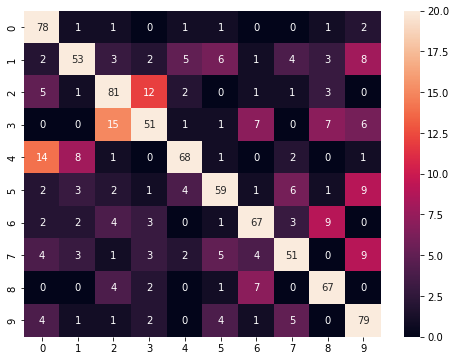

In [ ]:
conf = confusion_matrix(np.argmax(Y_test, axis=1), pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, fmt="d", vmax=20)

##### TODO - figure out how to convert mel_specs back to raw audio (to better see misclassifications)

### Synthetic Speech Commands dataset conversion: ###

In [ ]:
#### BATCH CONVERSION for second (slower) set ####
### TODO: figure out best values for n_fft, hop_length
n_fft = 2048 # number of samples in a window per fft
hop_length = 512 # amount of samples we are shifting after each fft
mel_spectrograms_2 = [] # list to store each converted signal

### actual conversion process
for signal in audio_signals_2:
  ms = signal_to_mel_spectrogram(signal, hop_length, n_fft)
  mel_spectrograms_2.append(ms)

In [ ]:
### Final X,Y data:
# X = mel_spectrograms_2
# Y = labels_2

#print(mel_spectrograms_2[4].shape)

mel_spectrograms_2 = np.array(mel_spectrograms_2)
labels_2 = np.array(labels_2)
print(mel_spectrograms_2.shape)
print(labels_2.shape)


In [ ]:
### creating X_train/X_test, Y_train/Y_test data splits
X_train_2, y_train_2, X_test_2, y_test_2 = split_data(mel_spectrograms_1, labels_1)
print(X_train_2.shape)
print(y_train_2.shape)
print(X_test_2.shape)
print(y_test_2.shape)


#### model

In [ ]:
# reshaping 3D tensors to 4D tensors for fully-connected layers
X_train_2 = X_train_2.reshape(-1, FIXME, FIXME, 1) # FIXME (batch, rows, columns, channels)
# 60000*28*28
# np.extend_dims(X_train, -1)
X_test_2 = X_test_2.reshape(-1, FIXME, FIXME, 1) # FIXME (batch, rows, columns, channels)

# it is in int8 format, the neural network requires float32, convert the arrays to float32
X_train_2 = X_train_2.astype("float32")
X_test_2 = X_test_2.astype("float32")

### converting Y_train/Y_test from explicit digits (0,...,9) to categorical (ex. 5 -> [0,0,0,0,0,1,0,0,0,0])
nb_classes_2=30
Y_train_2 = to_categorical(y_train_2, nb_classes_2)
Y_test_2 = to_categorical(y_test_2, nb_classes_2)

In [ ]:
### for testing purposes
words = np.asarray(range(nb_classes_2))
print(Y_train_2[0].astype(np.int))

##### defining the model

In [ ]:
#from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten

model2 = Sequential()
model2.add(Conv2D(6, (5,5), activation='relu', kernel_initializer=HeNormal(), input_shape=(FIXME,FIXME,1,)))
model2.add(MaxPool2D()) 
model2.add(Conv2D(16, (5,5), activation='relu', kernel_initializer=HeNormal()))
model2.add(Flatten())
model2.add(Dense(nb_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
model2.input

##### training

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy') # Early stopping

In [ ]:
network_history = model2.fit(X_train, Y_train, batch_size=128, 
                            epochs=10, verbose=1, validation_split=0.2, 
                            callbacks=[es])

#### Evaluation

In [ ]:
print(model2.evaluate(X_test_2, Y_test_2))

In [ ]:
preds_2=model2.predict(X_test_2)

In [ ]:
preds_2.shape

In [ ]:
preds_2[0], Y_test_2[0]

In [ ]:
pred_labels_2=np.argmax(preds_2, axis=1)

In [ ]:
pred_labels_2[0]

#### Evaluation cont (confusion matrix/misclassifications)

In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix
#import seaborn as sns

In [ ]:
print(classification_report(np.argmax(Y_test_2, axis=1), pred_labels_2))

In [ ]:
conf_2 = confusion_matrix(np.argmax(Y_test_2, axis=1), pred_labels_2)
plt.figure(figsize=(8,6))
sns.heatmap(conf_2, annot=True, fmt="d", vmax=20)